In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models
import random

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
import main.seir.uncertainty as uncertainty_module
from utils.generic.create_report import save_dict_and_create_report_simple
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles

import yaml

In [30]:
predictions_dict = {}

In [31]:
config_filename = 'undetected_simulated.yaml'
config = read_config(config_filename)

In [32]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_21102020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 167                 | 168                 | 169                 | 170                 | 171                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-10 00:00:00 | 2020-10-11 00:00:00 | 2020-10-12 00:00:00 | 2020-10-13 00:00:00 | 2020-10-14 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 220192.43           | 222448.71           | 224674.14           | 226856.71           | 228948.29  

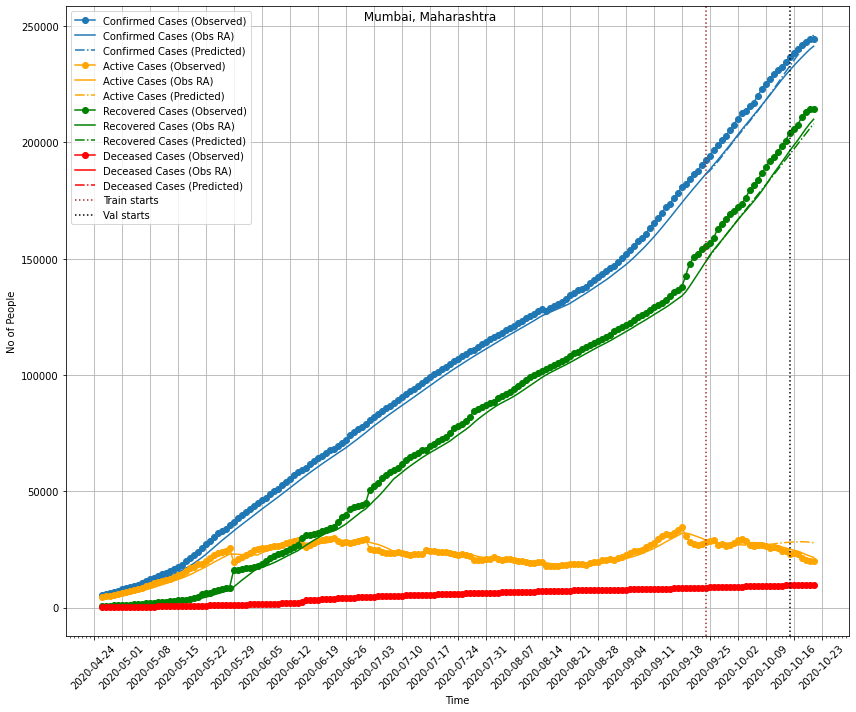

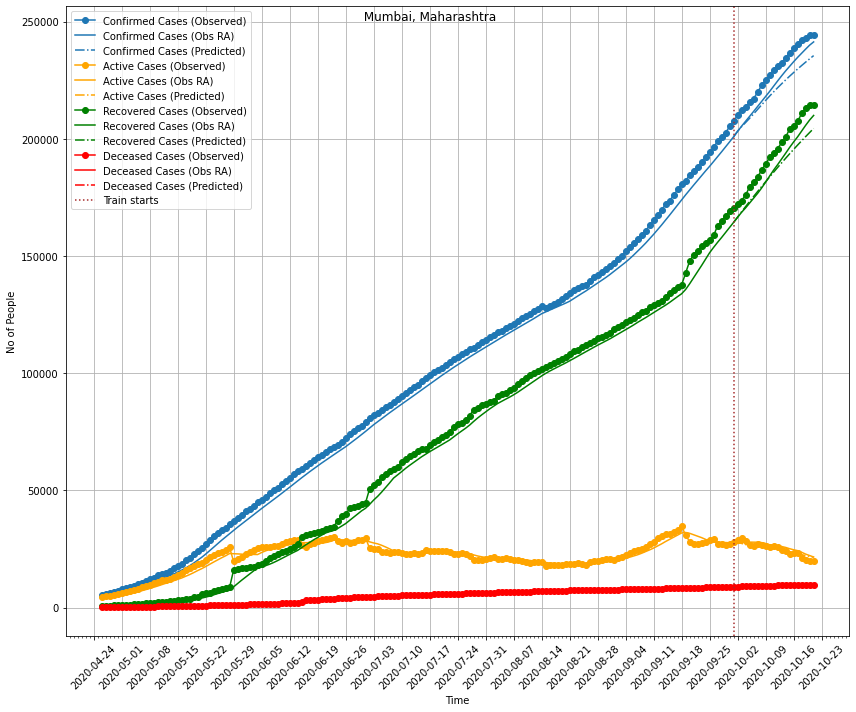

In [33]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [34]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.7770157753611168,
 'I_D_hosp_ratio': 0.16119628590066887,
 'I_U_hosp_ratio': 0.001979572192668533,
 'P_fatal': 0.05600735480860763,
 'T_inc': 4.641021730120739,
 'T_inf_D': 3.9204719337133556,
 'T_inf_U': 3.8125751510261203,
 'T_recov_fatal': 39.11666401608489,
 'T_recov_severe': 11.390975839997497,
 'beta': 0.24268199359376008,
 'd': 0.6478224907741731}

## Loss Dataframes

In [35]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.00165779739375993,
 'I_D_hosp_ratio': 0.22089711302826678,
 'I_U_hosp_ratio': 0.45303852155647223,
 'P_fatal': 0.03513419919269886,
 'T_inc': 5.182338161935817,
 'T_inf_D': 2.0651458184241296,
 'T_inf_U': 6.450995968088759,
 'T_recov_fatal': 32.436218967577375,
 'T_recov_severe': 11.794638127269357,
 'beta': 0.0431205227817837,
 'd': 0.06829951467520237}

### M1 Loss DataFrame

In [36]:
predictions_dict['m1']['df_loss']

,train,val
total,3.08178,0.937625
active,4.301,31.0242
recovered,3.78479,4.06689
deceased,1.08517,2.36729


### M2 Loss DataFrame

In [37]:
predictions_dict['m2']['df_loss']

,train
total,3.79007
active,3.72249
recovered,4.19553
deceased,2.39734


## Sensitivity Plot

In [ ]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
# predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

getting forecasts ..
3it [00:00, 24.01it/s]getting forecasts ..
1000it [00:54, 18.47it/s]
4it [00:00, 32.90it/s]getting forecasts ..
1000it [01:26, 11.51it/s]


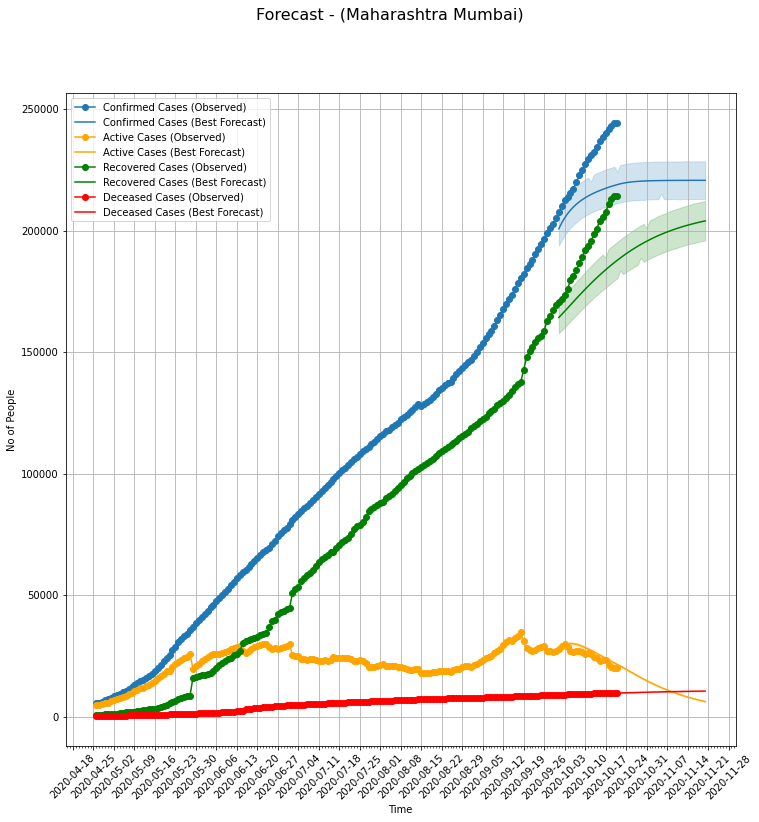

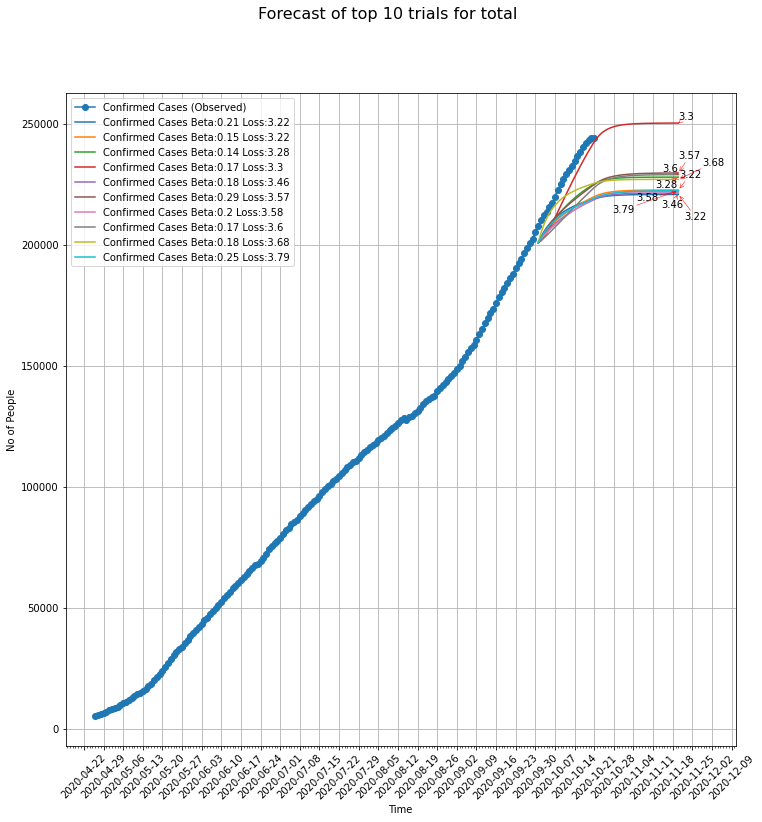

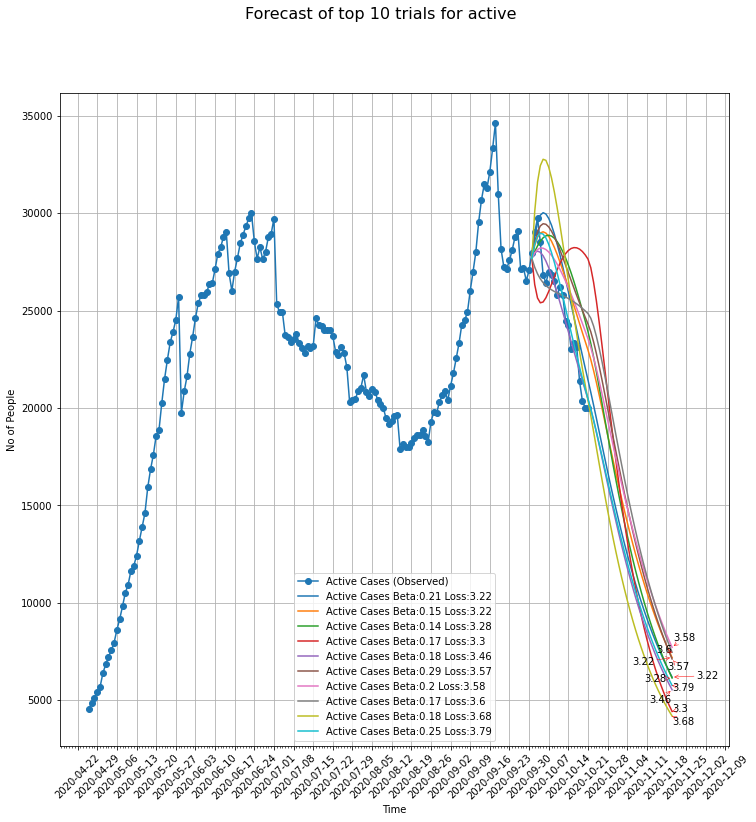

In [27]:
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'], tests_done=10000)

predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=True)

predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'], tests_done=10000)

predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'], tests_done=10000)

kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])
                               
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

In [ ]:
predictions_dict['m1']['trials_processed']['predictions']

## Uncertainty + Uncertainty Forecasts

In [ ]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

In [ ]:
uncertainty.beta_loss

In [ ]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']

In [ ]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

In [ ]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)

In [ ]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## Create Report

In [ ]:
save_dict_and_create_report_simple(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [ ]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [ ]:
log_wandb(predictions_dict)

## Create All Trials Output

In [ ]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')